# Some Typical Financial Calculations

This notebook showcases some classical finance calculations, which requires regressions, loops, root solving, optimisation and more. Details about these techniques are found in the other tutorials (notebooks).

The notebook *(a)* estimates CAPM equations and autocorrelations; *(b)* implements a simple trading strategy; *(c)* calculates Value at Risk using a simple model for time-varying volatility; *(d)* calculates the Black-Scholes option price and implied volatility; *(e)* calculates and draws the mean-variance frontier.

## Load Packages and Extra Functions

The [Roots](https://github.com/JuliaMath/Roots.jl) package solves non-linear equations, [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) defines distribution functions for a large number of distrunitions, and [StatsBase](https://github.com/JuliaStats/StatsBase.jl) has methods for estimating autocorrelations etc. The other packages are Standard Libraries (they come with the Julia installer).

In [1]:
using Printf, Dates, DelimitedFiles, LinearAlgebra, Roots, Distributions, StatsBase

include("src/printmat.jl");

In [2]:
using Plots
default(size = (480,320),fmt = :png)

# Load Data

In [3]:
x   = readdlm("Data/MyData.csv",',',skipstart=1)        #monthly return data
ym  = round.(Int,x[:,1])     #yearmonth, like 200712
Rme = x[:,2]                 #market excess return
Rf  = x[:,3]                 #interest rate
R   = x[:,4]                 #return on small growth stocks
Re  = R - Rf                 #excess returns
T   = size(Rme,1)

dN = Date.(string.(ym),"yyyymm")  #convert to string and then Julia Date
printmat(dN[1:4],Re[1:4],Rme[1:4])

1979-01-01    10.190     4.180
1979-02-01    -2.820    -3.410
1979-03-01    10.900     5.750
1979-04-01     2.470     0.050



# CAPM

The CAPM regression is

$R_{t}^{e}  =\alpha+\beta R_{mt}^{e}+\varepsilon_{t}$,

where $R_{t}^{e}$ is the excess return of test asset and $R_{mt}^{e}$ is the market excess return. Theory says that $\alpha=0$, which is easily tested.

### A Remark on the Code
- The OLS coeffcients on the regressors in `x` are called `b` in the code below. Given the way `x` is defined, `b[1]` corresponds to $\alpha$ and `b[2]` to $\beta$.
- There are clearly packages that can do OLS, but we do not use them here.

In [4]:
x    = [ones(T) Rme]             #regressors
y    = copy(Re)                  #to get standard OLS notation
b    = x\y                       #OLS, intercept and slope
u    = y - x*b                   #residuals
covb = inv(x'x)*var(u)           #cov(b), see any textbook
stdb = sqrt.(diag(covb))         #std(b)
R2   = 1 - var(u)/var(y)

printblue("Regression results:\n")
printmat([b stdb b./stdb],colNames=["coeff","std","t-stat"],rowNames=["α","β"])
printlnPs("R2: ",R2)
printlnPs("no. of observations: ",T)

Regression results:

      coeff       std    t-stat
α    -0.504     0.304    -1.656
β     1.341     0.066    20.427

      R2:      0.519
no. of observations:    388    


# Return Autocorrelation

That is, the correlation of $R_{t}^{e}$ and $R_{t-s}^{e}$. 

It can be shown that the t-stat of an autocorrelation is $\sqrt{T}$ times the autocorrelation.

### A Remark on the Code
- `autocor(Re,plags)` from the `StatsBase` package estimates the autocorrelations for the lags defines in the rang (or vector) `plags`.

In [5]:
plags = 1:5
ρ = autocor(Re,plags)         #using the StatsBase package

printblue("Autocorrelations:\n")
printmat([ρ sqrt(T)*ρ],colNames=["autocorr","t-stat"],rowNames=string.(plags),cell00="lag")

Autocorrelations:

lag  autocorr    t-stat
1       0.216     4.253
2       0.002     0.046
3      -0.018    -0.359
4      -0.065    -1.289
5      -0.027    -0.536



# A Trading Strategy

The next cell implements a very simple momentum trading strategy. 

1. If $R_{t-1}^{e}\ge0$, then we hold the market index and shorten the riskfree from $t-1$ to $t$. This means that we will earn $R_{t}^{e}$.

2. Instead,  if $R_{t-1}^{e}<0$, then we do the opposite. This means that we will earn $-R_{t}^{e}$. 

This simple strategy could be coded without using a loop, but "vectorization" does not speed up much.

We compare with a "passive" portfolio, which is just holding the asset all the time (and earning $R_{t}^{e}$ in each period).

In [6]:
(w,Rp)  = (fill(NaN,T),fill(NaN,T))
for t = 2:T
  w[t]  = ifelse(Re[t-1] < 0,-1,1)         #w is -1 or 1
  Rp[t] = w[t]*Re[t]
end

R_all = hcat(Rp[2:end],Re[2:end])          #Tx2, matrix of both returns
μ     = mean(R_all,dims=1)
σ     = std(R_all,dims=1)

printblue("The annualized mean excess return and Sharpe ratios of the strategy and a passive portfolio:\n")
xx = [μ*12;sqrt(12)*μ./σ]
printmat(xx;rowNames=["mean","SR"],colNames=["strategy","passive"])

The annualized mean excess return and Sharpe ratios of the strategy and a passive portfolio:

      strategy   passive
mean    26.733     3.329
SR       0.932     0.112



# Value at Risk

The next cell constructs an simple estimate of $\sigma_t^2$ as a backward looking moving average:

$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) (R_{t-1}^e -\mu_{t-1})^2$,
where $\mu_{t}=\lambda \mu_{t-1} + (1-\lambda) R_{t-1}^e$

Then, we calculate the 95% VaR by assuming a N$(\mu,\sigma_t^2)$ distribution:

$\textrm{VaR}_{t} = - (\mu_t-1.64\sigma_t)$.

In [7]:
(μ₀,σ₀) = (0.5,5.0)          #some starting values for obs t=0

λ = 0.94
(μ,σ²) = (fill(μ₀,T),fill(σ₀^2,T))    #vectors, time-varying mean and variance
for t in 2:T
    μ[t]  = λ*μ[t-1]  + (1-λ)*Rme[t-1]
    σ²[t] = λ*σ²[t-1] + (1-λ)*(Rme[t-1]-μ[t-1])^2    #RiskMetrics approach
end

VaR95 = -(μ .- 1.64*sqrt.(σ²));      #VaR at 95% level

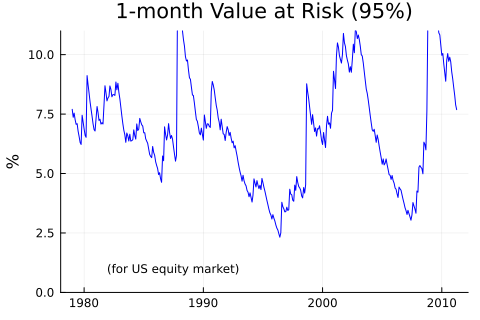

In [8]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,VaR95,
           color = :blue,
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           ylim = (0,11),
           title = "1-month Value at Risk (95%)",
           ylabel = "%",
           annotation = (Date(1982),1,text("(for US equity market)",8,:left)) )
display(p1)

# Options

## Black-Scholes Option Price

Let $S$ be the the current spot price of an asset and $y$ be the interest rate.

The Black-Scholes formula for a European call option with strike price $K$ and time to expiration $m$ is

$C  =S\Phi(d_{1})  -e^{-ym}K\Phi(d_{2})$, where

$d_{1} =\frac{\ln(S/K)+(y+\sigma^{2}/2)m}{\sigma\sqrt{m}} \ \text{ and } \ d_{2}=d_{1}-\sigma\sqrt{m}$ 

and where $\Phi(d)$ denotes the probability of $x\leq d$ when $x$ has an $N(0,1)$ distribution. All variables except the volatility ($\sigma$) are directly observable.

### A Remark on the Code
- `cdf(Normal(0,1),x)` defines the cdf of a N$(0,1)$ distribution, using the `Distributions.jl` package.

In [9]:
"""
Pr(z<=x) for N(0,1)
"""
Φ(x) = cdf(Normal(0,1),x)     #a one-line function, to get standard notation


"""
Calculate Black-Scholes european call option price
"""
function OptionBlackSPs(S,K,m,y,σ)

  d1 = ( log(S/K) + (y+1/2*σ^2)*m ) / (σ*sqrt(m))
  d2 = d1 - σ*sqrt(m)
  c  = S*Φ(d1) - exp(-y*m)*K*Φ(d2)
  return c
end

OptionBlackSPs

In [10]:
σ = 0.4
c1 = OptionBlackSPs(10,10,0.5,0.1,σ)         #call price for a single K value
printlnPs("\n","call price according to Black-Scholes for a single K value: ",c1)

K = range(7,13,length=51)                    #call prices for several K values
c = OptionBlackSPs.(10,K,0.5,0.1,σ);

          
call price according to Black-Scholes for a single K value:      1.358


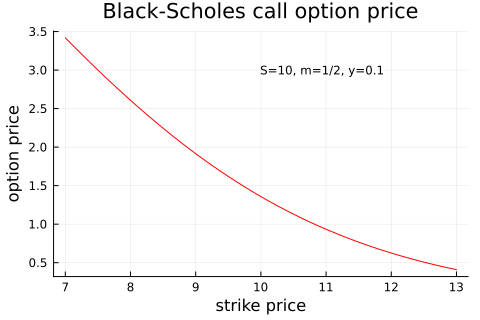

In [11]:
p1 = plot( K,c,
           color = :red,
           legend = false,
           title = "Black-Scholes call option price",
           xlabel = "strike price",
           ylabel = "option price",
           annotation = (10,3,text("S=10, m=1/2, y=0.1",8,:left)) )
display(p1)

# Implied Volatility

...is the $\sigma$ value that makes the Black-Scholes equation give the same option price as observed on the market. It is often interpreted as the "market uncertainty."

The next cell uses the call option price calculated above as the market price. The implied volatility should then equal the volatility used above (this is a way to check your coding).

The subsequent cells instead use some data on options on German government bonds and calculate the $\sigma$ for each of them.`

### A Remark on the Code
- the `find_zero()` function from the `Roots.jl` package solve a non-linear function for its root (in terms of one of the inputs of the function). In the cell below, we thus solve for the `σ` value that makes `OptionBlackSPs(10,10,0.5,0.1,σ)-c1` equal to zero.

In [12]:
                                #solve for implied vol
iv = find_zero(σ->OptionBlackSPs(10,10,0.5,0.1,σ)-c1,(0.00001,5))

printlnPs("Implied volatility: ",iv,", compare with: $σ")

Implied volatility:      0.400, compare with: 0.4


In [13]:
#  LIFFE Bunds option data, trade date April 6, 1994
K = [                        #strike prices
      92.00;  94.00;  94.50;  95.00;  95.50;  96.00;  96.50;  97.00;
      97.50;  98.00;  98.50;  99.00;  99.50;  100.0;  100.5;  101.0;
     101.5;  102.0;  102.5;  103.0;  103.5 ];
C = [                        #call prices
      5.13;    3.25;    2.83;    2.40;    2.00;    1.64;    1.31;    1.02;
      0.770;   0.570;   0.400;   0.280;   0.190;   0.130;  0.0800;  0.0500;
      0.0400;  0.0300;  0.0200;  0.0100;  0.0100 ];
S = 97.05                #spot price
m = 48/365               #time to expiry in years
y = 0.0                  #Interest rate: LIFFE=>no discounting
N = length(K)

21

In [14]:
iv = fill(NaN,N)       #looping over strikes
for i in 1:N
  iv[i] = find_zero(sigma->OptionBlackSPs(S,K[i],m,y,sigma)-C[i],(0.00001,5))
end

printblue("From Bunds options data:\n")
printmat(K,iv,colNames=["strike","σ"])

From Bunds options data:

    strike         σ
    92.000     0.094
    94.000     0.081
    94.500     0.081
    95.000     0.078
    95.500     0.075
    96.000     0.074
    96.500     0.072
    97.000     0.071
    97.500     0.070
    98.000     0.069
    98.500     0.068
    99.000     0.067
    99.500     0.067
   100.000     0.068
   100.500     0.067
   101.000     0.067
   101.500     0.070
   102.000     0.073
   102.500     0.074
   103.000     0.072
   103.500     0.077



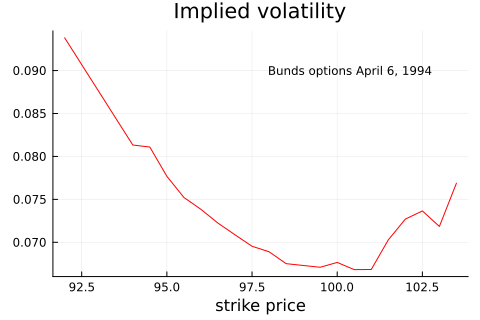

In [15]:
p1 = plot( K,iv,
           color = :red,
           legend =false,
           title = "Implied volatility",
           xlabel = "strike price",
           annotation = (98,0.09,text("Bunds options April 6, 1994",8,:left)) )
display(p1)

# Mean-Variance Frontier

Given a vector of average returns ($\mu$) and a variance-covariance matrix ($\Sigma$), the mean-variance frontier shows the lowest possible portfolio uncertainty for a given expected portfolio return (denoted `μˣ` below).

It is thus the solution to a quadratic minimization problem. The cells below will use matrix formulas for this solution, but we often have to resort to numerical methods (especially when there are portfolio restrictions).

The mean-variance frontier is typically plotted with the portfolio standard deviation (*not* the variance) on the horizontal axis and the portfolio expected return $\mu\text{star}$ on the vertical axis.

We calculate and plot two different mean-variance frontiers: *(1)* when we only consider risky assets; *(2)* when we also consider a risk-free asset.

### A Remark on the Code
The calculations for the mean-variance frontiers are in two functions (for the case of only risky assets, and for risky and a riskfree asset). The calculations involve solving a system of linear equations (or calculating a matrix inverse) for each value of the expected return `μˣ`. To speed up the calculations we use the `factorize()` function from the `LinearAlgebra` standard library.

In [16]:
μ = [11.5, 9.5, 6]/100          #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2
Rf = 0.03                       #riskfree return (an interest rate)

println("μ: ")
printmat(μ)
println("Σ: ")
printmat(Σ)
println("Rf: ")
printmat(Rf)

μ: 
     0.115
     0.095
     0.060

Σ: 
     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

Rf: 
     0.030



In [17]:
"""
    MVCalc(μˣ,μ,Σ)

Calculate the std and weights of a portfolio (with mean return μˣ) on MVF of risky assets.

# Input
- `μˣ::Vector`:    K vector, mean returns to calculate results for
- `μ::Vector`:     n vector, mean returns
- `Σ::Matrix`:     nxn, covariance matrix of returns, can contain riskfree assets

# Output
- `StdRp::Vector`:    K vector, standard deviation of mean-variance portfolio (risky only) with mean μˣ
- `w_p::Matrix`:      Kxn, portfolio weights of       ""

"""
function MVCalc(μˣ,μ,Σ) #the std of a portfolio on MVF of risky assets
    (K,n) = (length(μˣ),length(μ))
    A = [Σ        μ ones(n);   #A is just a name of this matrix, it's not asset A
         μ'       0 0;
         ones(n)' 0 0];
    Af = factorize(A)          #factorize so we can solve wλδ_i repeatedly (and fast)
    (w,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i in 1:K                #loop over μˣ[i]
        wλδ_i    = Af\[zeros(n);μˣ[i];1]
        w_i      = wλδ_i[1:n]
        StdRp[i] = sqrt(w_i'Σ*w_i)
        w[i,:]   = w_i
    end
    return StdRp,w
end


"""
Calculate the std of a portfolio (with mean μˣ) on MVF of (Risky,Riskfree)
"""
function MVCalcRf(μˣ,μ,Σ,Rf)
    (K,n) = (length(μˣ),length(μ))
    μᵉ = μ .- Rf
    A  = [Σ   μᵉ;
          μᵉ' 0]
    Af = factorize(A)
    (w,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i in 1:K
      wλ_i     = Af\[zeros(n);(μˣ[i]-Rf)]
      w_i      = wλ_i[1:n]
      StdRp[i] = sqrt(w_i'Σ*w_i)
      w[i,:]   = w_i
    end
    return StdRp,w
end

MVCalcRf

In [18]:
μˣ = range(Rf,0.15,length=201)
L     = length(μˣ)

StdRp = MVCalc(μˣ,μ,Σ)[1];    #risky assets only, [1] to get the first output

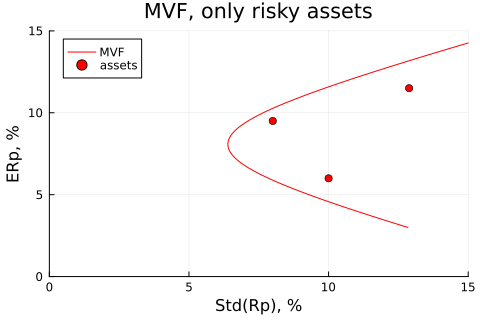

In [19]:
p1 = plot( StdRp*100,μˣ*100,
           linecolor = :red,
           xlim = (0,15),
           ylim = (0,15),
           label = "MVF",
           legend = :topleft,
           title = "MVF, only risky assets",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)

In [20]:
StdRpRf = MVCalcRf(μˣ,μ,Σ,Rf)[1];         #with riskfree too

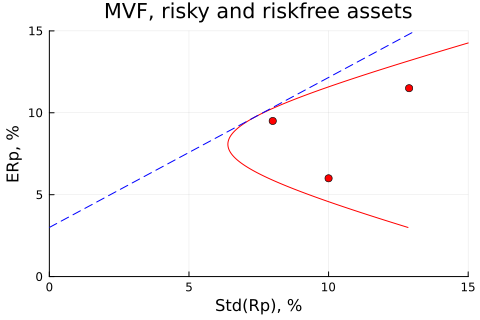

In [21]:
p1 = plot( [StdRp StdRpRf]*100,[μˣ μˣ]*100,
           legend = nothing,
           linestyle = [:solid :dash],
           linecolor = [:red :blue],
           xlim = (0,15),
           ylim = (0,15),
           title = "MVF, risky and riskfree assets",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red)
display(p1)